In [1]:
#!conda install -c conda-forge rdkit --solver=classic -y
#source

In [24]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [25]:


# Load your CSV
#df = pd.read_csv('drug_summary_data.csv')
df = pd.read_csv('drug_summary_data_4code_supplementary_figure.csv')

df

,enamine_name,enamine_id,short_id,smiles,normalized_rlu_10uM,off_target,toxicity,group
0,Z5052318887,Z5052318887,8887,CC=1C=CC=CC1CCC(=O)N2C[C@@H]3[C@@](CS3(=O)=O)(...,0.823305,2,2,7L1U
1,PV-006669822259,Z9331482459,2259,OC(=O)[C@@H]1C[C@@H](CN1C(=O)COC=2C=CC=3C=CC=C...,0.807176,2,2,7L1U
2,Z2017261328,Z2017261328,1328,COC=1C=CC(=CC1S(=O)(=O)NCC=2C=CC=C(C2)N(C)C)S(...,0.810388,2,2,7L1U
3,Z1679037537,Z1679037537,7537,COC=1C=CC=CC1CS(=O)(=O)NC(=O)CC(C=2C=CC=CC2)C=...,0.802209,2,2,7L1U
4,PV-006634533361,Z9331482532,3361,CC=1C=CC=C(C1)C=2N=C(C3=NNC=4C=CC=CC4C3=O)N(CC...,1.070507,2,2,7L1U
...,...,...,...,...,...,...,...,...
91,Almorexant,Almorexant,Almorexant,CNC([C@@H](C1=CC=CC=C1)N2CCC3=CC(OC)=C(OC)C=C3...,NaN,1,1,Published
92,TCS-1102,TCS-1102,TCS-1102,O=C([C@H]1N(C(CSC2=NC3=CC=CC=C3N2C)=O)CCC1)NC4...,0.013520,0,0,Published
93,SB-674042,SB-674042,SB-674042,FC1=C(C2=C(C(N3[C@H](CC4=NN=C(C5=CC=CC=C5)O4)C...,0.046305,1,0,Published
94,EMPA,EMPA,EMPA,O=C(N(CC)CC1=CC=CN=C1)CN(C2=CC=C(OC)N=C2)S(=O)...,0.034269,2,0,Published


In [26]:
# Step 2: Generate fingerprints from SMILES
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)

df['fingerprint'] = df['smiles'].apply(smiles_to_fingerprint)
df = df[df['fingerprint'].notnull()].reset_index(drop=True)  # Drop rows with invalid SMILES
df

[17:18:29] DEPRECATION WARNING: please use MorganGenerator
[17:18:29] DEPRECATION WARNING: please use MorganGenerator
[17:18:29] DEPRECATION WARNING: please use MorganGenerator
[17:18:29] DEPRECATION WARNING: please use MorganGenerator
[17:18:29] DEPRECATION WARNING: please use MorganGenerator
[17:18:29] DEPRECATION WARNING: please use MorganGenerator
[17:18:29] DEPRECATION WARNING: please use MorganGenerator
[17:18:29] DEPRECATION WARNING: please use MorganGenerator
[17:18:29] DEPRECATION WARNING: please use MorganGenerator
[17:18:29] DEPRECATION WARNING: please use MorganGenerator
[17:18:29] DEPRECATION WARNING: please use MorganGenerator
[17:18:29] DEPRECATION WARNING: please use MorganGenerator
[17:18:29] DEPRECATION WARNING: please use MorganGenerator
[17:18:29] DEPRECATION WARNING: please use MorganGenerator
[17:18:29] DEPRECATION WARNING: please use MorganGenerator
[17:18:29] DEPRECATION WARNING: please use MorganGenerator
[17:18:29] DEPRECATION WARNING: please use MorganGenerat

,enamine_name,enamine_id,short_id,smiles,normalized_rlu_10uM,off_target,toxicity,group,fingerprint
0,Z5052318887,Z5052318887,8887,CC=1C=CC=CC1CCC(=O)N2C[C@@H]3[C@@](CS3(=O)=O)(...,0.823305,2,2,7L1U,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,PV-006669822259,Z9331482459,2259,OC(=O)[C@@H]1C[C@@H](CN1C(=O)COC=2C=CC=3C=CC=C...,0.807176,2,2,7L1U,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Z2017261328,Z2017261328,1328,COC=1C=CC(=CC1S(=O)(=O)NCC=2C=CC=C(C2)N(C)C)S(...,0.810388,2,2,7L1U,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Z1679037537,Z1679037537,7537,COC=1C=CC=CC1CS(=O)(=O)NC(=O)CC(C=2C=CC=CC2)C=...,0.802209,2,2,7L1U,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,PV-006634533361,Z9331482532,3361,CC=1C=CC=C(C1)C=2N=C(C3=NNC=4C=CC=CC4C3=O)N(CC...,1.070507,2,2,7L1U,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
91,Almorexant,Almorexant,Almorexant,CNC([C@@H](C1=CC=CC=C1)N2CCC3=CC(OC)=C(OC)C=C3...,NaN,1,1,Published,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
92,TCS-1102,TCS-1102,TCS-1102,O=C([C@H]1N(C(CSC2=NC3=CC=CC=C3N2C)=O)CCC1)NC4...,0.013520,0,0,Published,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
93,SB-674042,SB-674042,SB-674042,FC1=C(C2=C(C(N3[C@H](CC4=NN=C(C5=CC=CC=C5)O4)C...,0.046305,1,0,Published,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
94,EMPA,EMPA,EMPA,O=C(N(CC)CC1=CC=CN=C1)CN(C2=CC=C(OC)N=C2)S(=O)...,0.034269,2,0,Published,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [27]:
# Step 3: Compute pairwise Tanimoto similarity matrix
n = len(df)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        sim = DataStructs.TanimotoSimilarity(df.at[i, 'fingerprint'], df.at[j, 'fingerprint'])
        similarity_matrix[i, j] = sim
        similarity_matrix[j, i] = sim

# Convert to a distance matrix (1 - similarity)
distance_matrix = 1 - similarity_matrix

df

,enamine_name,enamine_id,short_id,smiles,normalized_rlu_10uM,off_target,toxicity,group,fingerprint
0,Z5052318887,Z5052318887,8887,CC=1C=CC=CC1CCC(=O)N2C[C@@H]3[C@@](CS3(=O)=O)(...,0.823305,2,2,7L1U,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,PV-006669822259,Z9331482459,2259,OC(=O)[C@@H]1C[C@@H](CN1C(=O)COC=2C=CC=3C=CC=C...,0.807176,2,2,7L1U,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Z2017261328,Z2017261328,1328,COC=1C=CC(=CC1S(=O)(=O)NCC=2C=CC=C(C2)N(C)C)S(...,0.810388,2,2,7L1U,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Z1679037537,Z1679037537,7537,COC=1C=CC=CC1CS(=O)(=O)NC(=O)CC(C=2C=CC=CC2)C=...,0.802209,2,2,7L1U,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,PV-006634533361,Z9331482532,3361,CC=1C=CC=C(C1)C=2N=C(C3=NNC=4C=CC=CC4C3=O)N(CC...,1.070507,2,2,7L1U,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
91,Almorexant,Almorexant,Almorexant,CNC([C@@H](C1=CC=CC=C1)N2CCC3=CC(OC)=C(OC)C=C3...,NaN,1,1,Published,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
92,TCS-1102,TCS-1102,TCS-1102,O=C([C@H]1N(C(CSC2=NC3=CC=CC=C3N2C)=O)CCC1)NC4...,0.013520,0,0,Published,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
93,SB-674042,SB-674042,SB-674042,FC1=C(C2=C(C(N3[C@H](CC4=NN=C(C5=CC=CC=C5)O4)C...,0.046305,1,0,Published,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
94,EMPA,EMPA,EMPA,O=C(N(CC)CC1=CC=CN=C1)CN(C2=CC=C(OC)N=C2)S(=O)...,0.034269,2,0,Published,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [28]:
# Step 4: Perform hierarchical clustering
condensed_dist = squareform(distance_matrix, checks=False)
Z = linkage(condensed_dist, method='average')  # or 'complete', 'ward', etc.

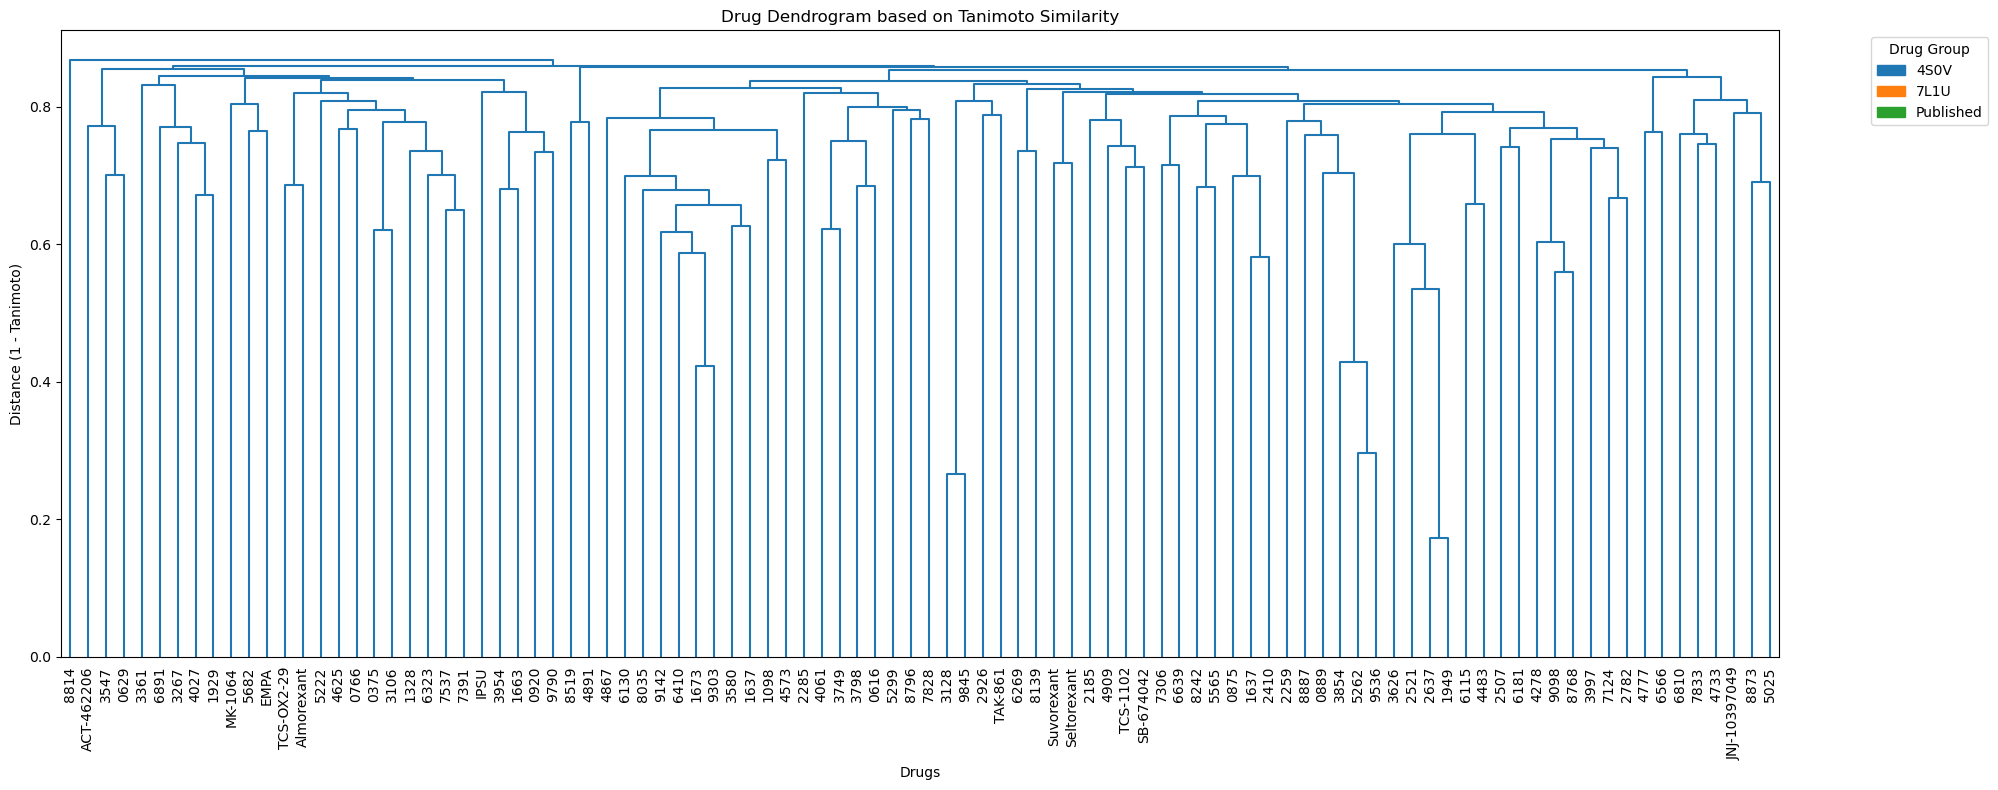

In [29]:
# Step 5: Plot dendrogram
fig, ax = plt.subplots(figsize=(20, 8))

# Optional: color by group
group_colors = sns.color_palette("hls", df['group'].nunique())
group_colors = sns.color_palette("tab10", df['group'].nunique())

group_lut = dict(zip(sorted(df['group'].unique()), group_colors))
row_colors = df['group'].map(group_lut)

labels = [f"{sid} (G{g})" for sid, g in zip(df['short_id'], df['group'])]

dendro = dendrogram(
    Z,
    labels=df['short_id'].values,
    leaf_rotation=90,
    leaf_font_size=10,
    ax=ax,
    color_threshold=0
)

import matplotlib.patches as mpatches

handles = [mpatches.Patch(color=group_lut[g], label=f'{g}') for g in sorted(group_lut)]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title='Drug Group')


# Optionally, color bar or annotations
plt.title("Drug Dendrogram based on Tanimoto Similarity")
plt.xlabel("Drugs")
plt.ylabel("Distance (1 - Tanimoto)")
plt.tight_layout()
plt.show()

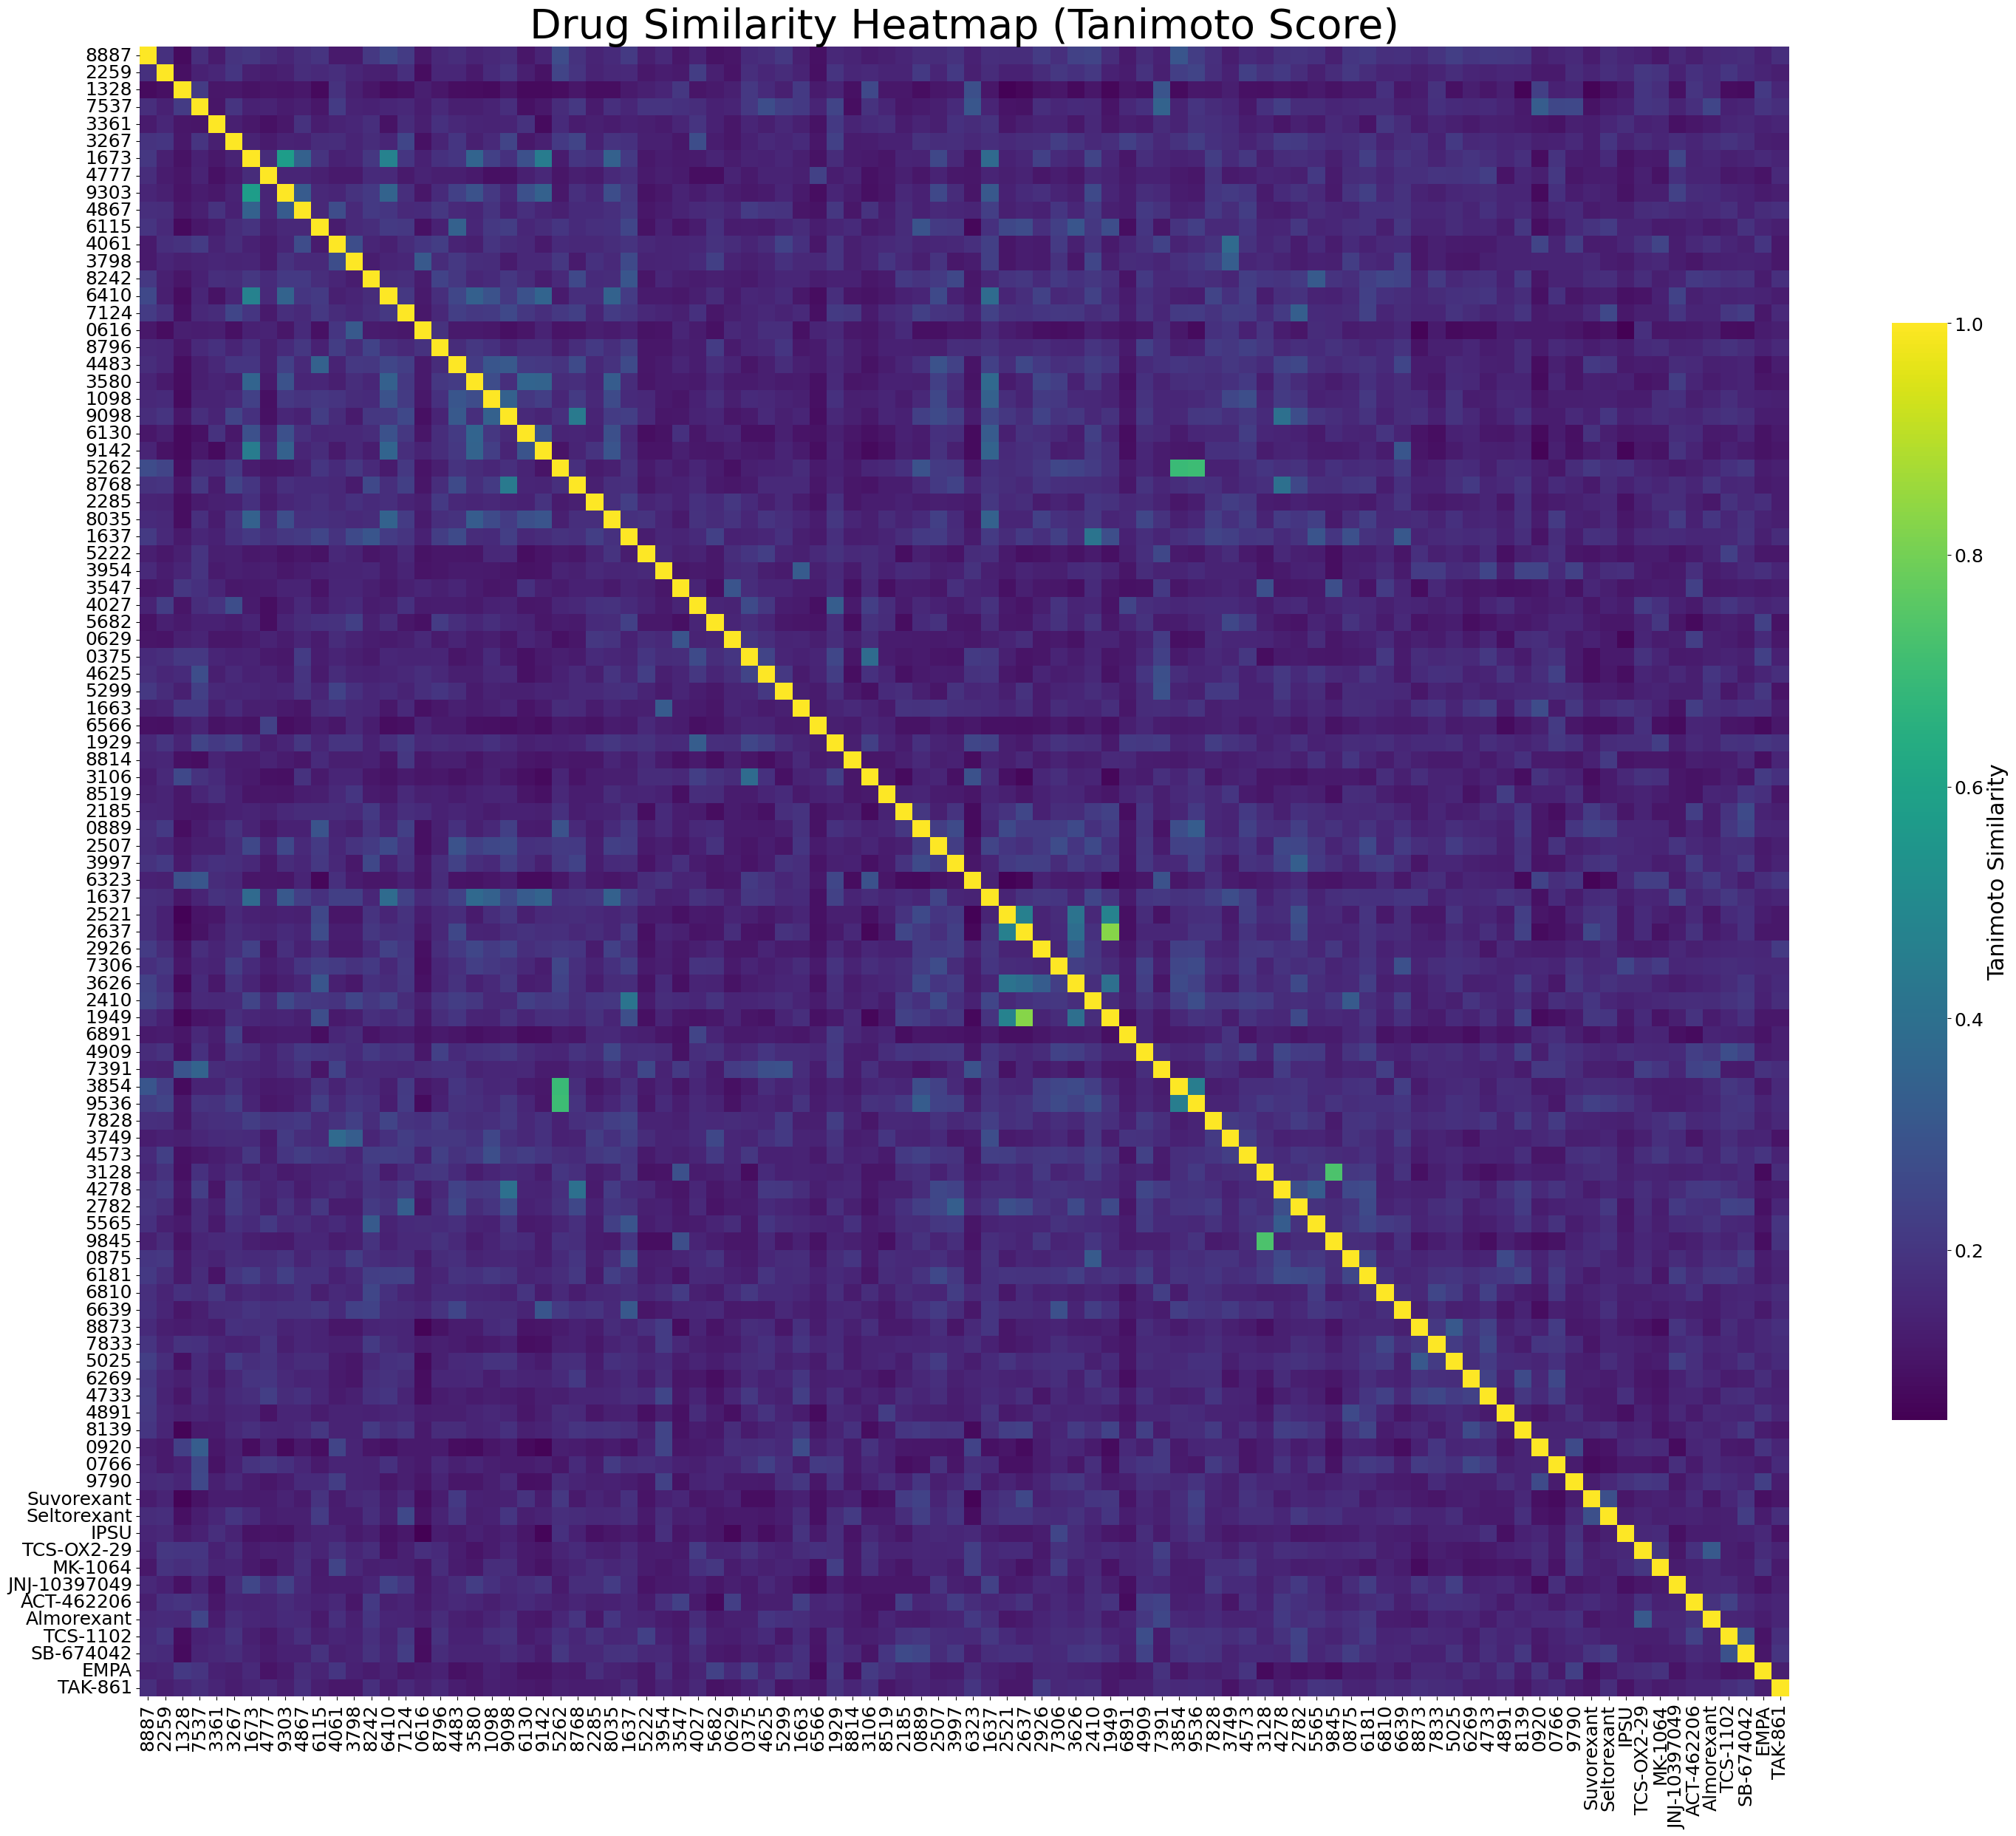

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get short_id labels for drugs
labels = df['short_id'].values

"""
# Plot heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(similarity_matrix, xticklabels=labels, yticklabels=labels,
            cmap="viridis", annot=False, square=True, cbar_kws={'label': 'Tanimoto Similarity'})
plt.title("Drug Similarity Heatmap (Tanimoto Score)", fontsize=40)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(rotation=0, fontsize=18)
plt.tight_layout()
plt.savefig('drug_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
"""

plt.figure(figsize=(30, 30))
ax = sns.heatmap(
    similarity_matrix,
    xticklabels=labels,
    yticklabels=labels,
    cmap="viridis",
    annot=False,
    square=True,
    cbar_kws={
        'label': 'Tanimoto Similarity',
        'shrink': 0.5   # 0.5 = 50% of normal height
    }
)

# Title and ticks
plt.title("Drug Similarity Heatmap (Tanimoto Score)", fontsize=40)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(rotation=0, fontsize=18)

# --- Adjust colorbar ---
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)       # font size of numbers
cbar.set_label('Tanimoto Similarity', fontsize=22)  # label font size

plt.tight_layout()
plt.savefig('drug_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


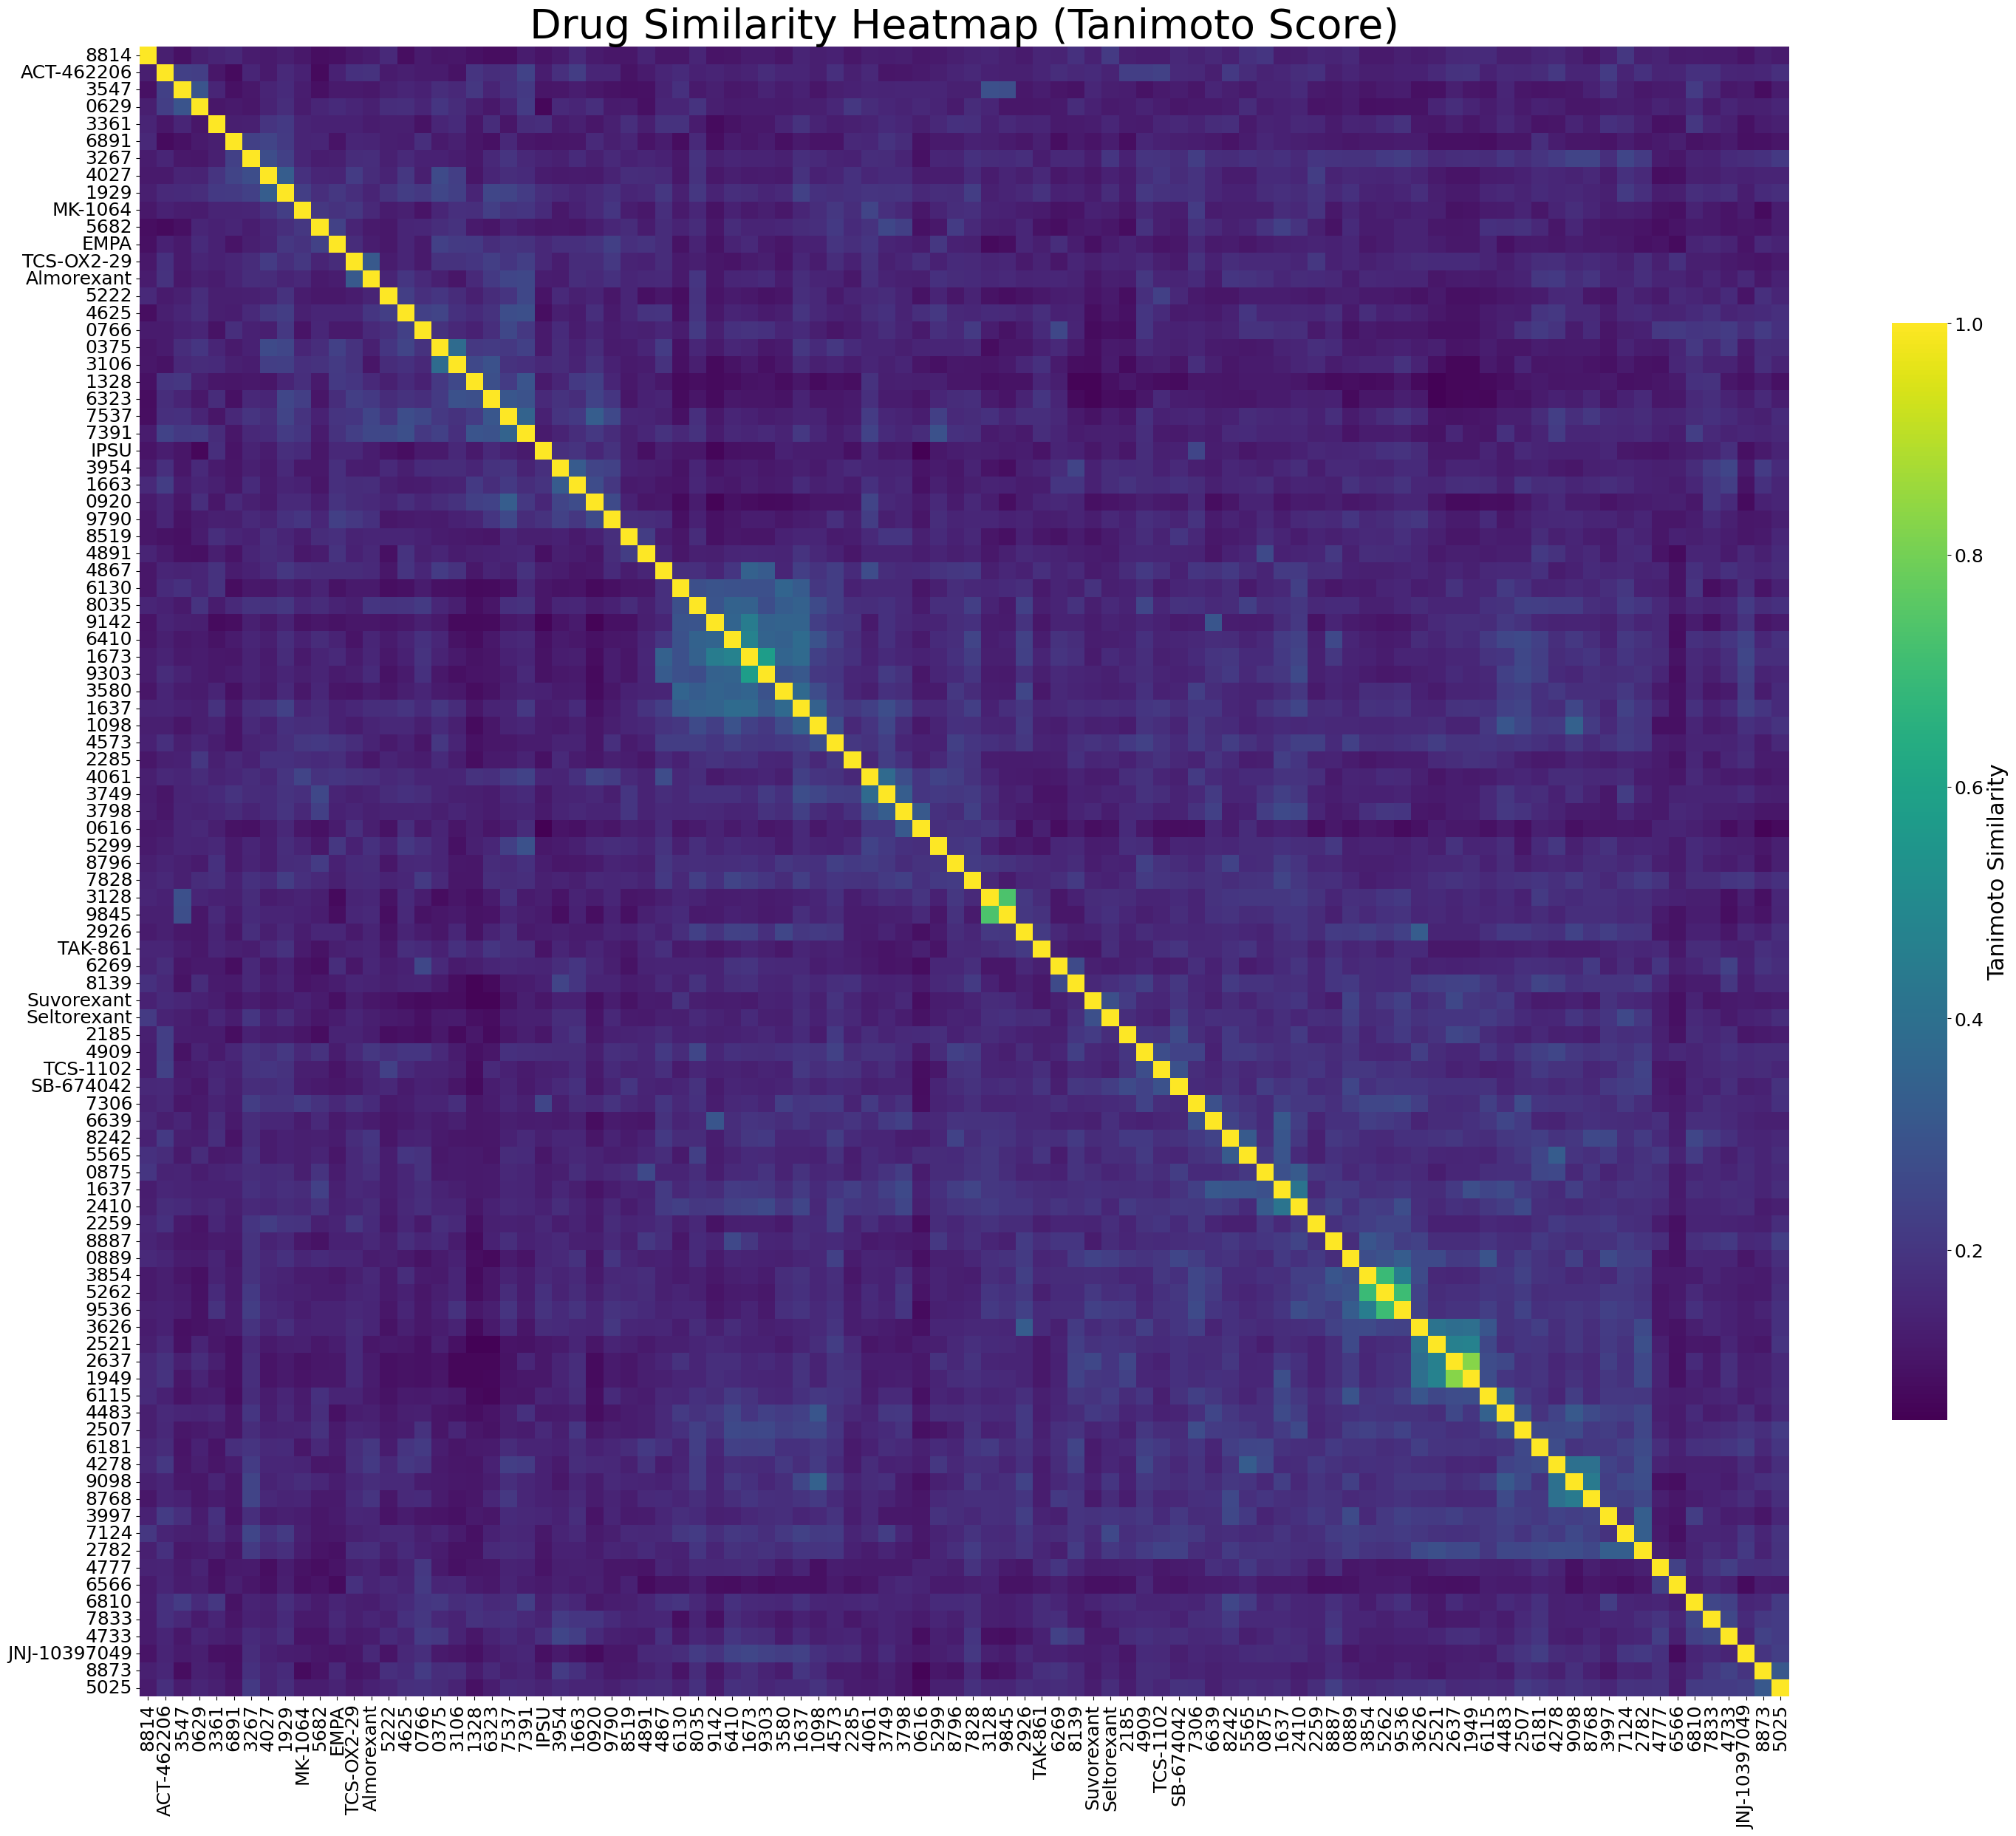

In [34]:
# Get the order of leaves from the dendrogram
leaf_order = dendro['leaves']

# Reorder similarity matrix and labels
reordered_matrix = similarity_matrix[leaf_order, :][:, leaf_order]
reordered_labels = df['short_id'].values[leaf_order]

# Plot heatmap with reordered data
plt.figure(figsize=(30, 30))
ax = sns.heatmap(
    reordered_matrix,
    xticklabels=reordered_labels,
    yticklabels=reordered_labels,
    cmap="viridis",
    annot=False,
    square=True,
    cbar_kws={
        'label': 'Tanimoto Similarity',
        'shrink': 0.5
    }
)

plt.title("Drug Similarity Heatmap (Tanimoto Score)", fontsize=40)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(rotation=0, fontsize=18)

# Adjust colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)
cbar.set_label('Tanimoto Similarity', fontsize=22)

plt.tight_layout()
plt.savefig('drug_heatmap_clustered.png', dpi=300, bbox_inches='tight')
plt.show()

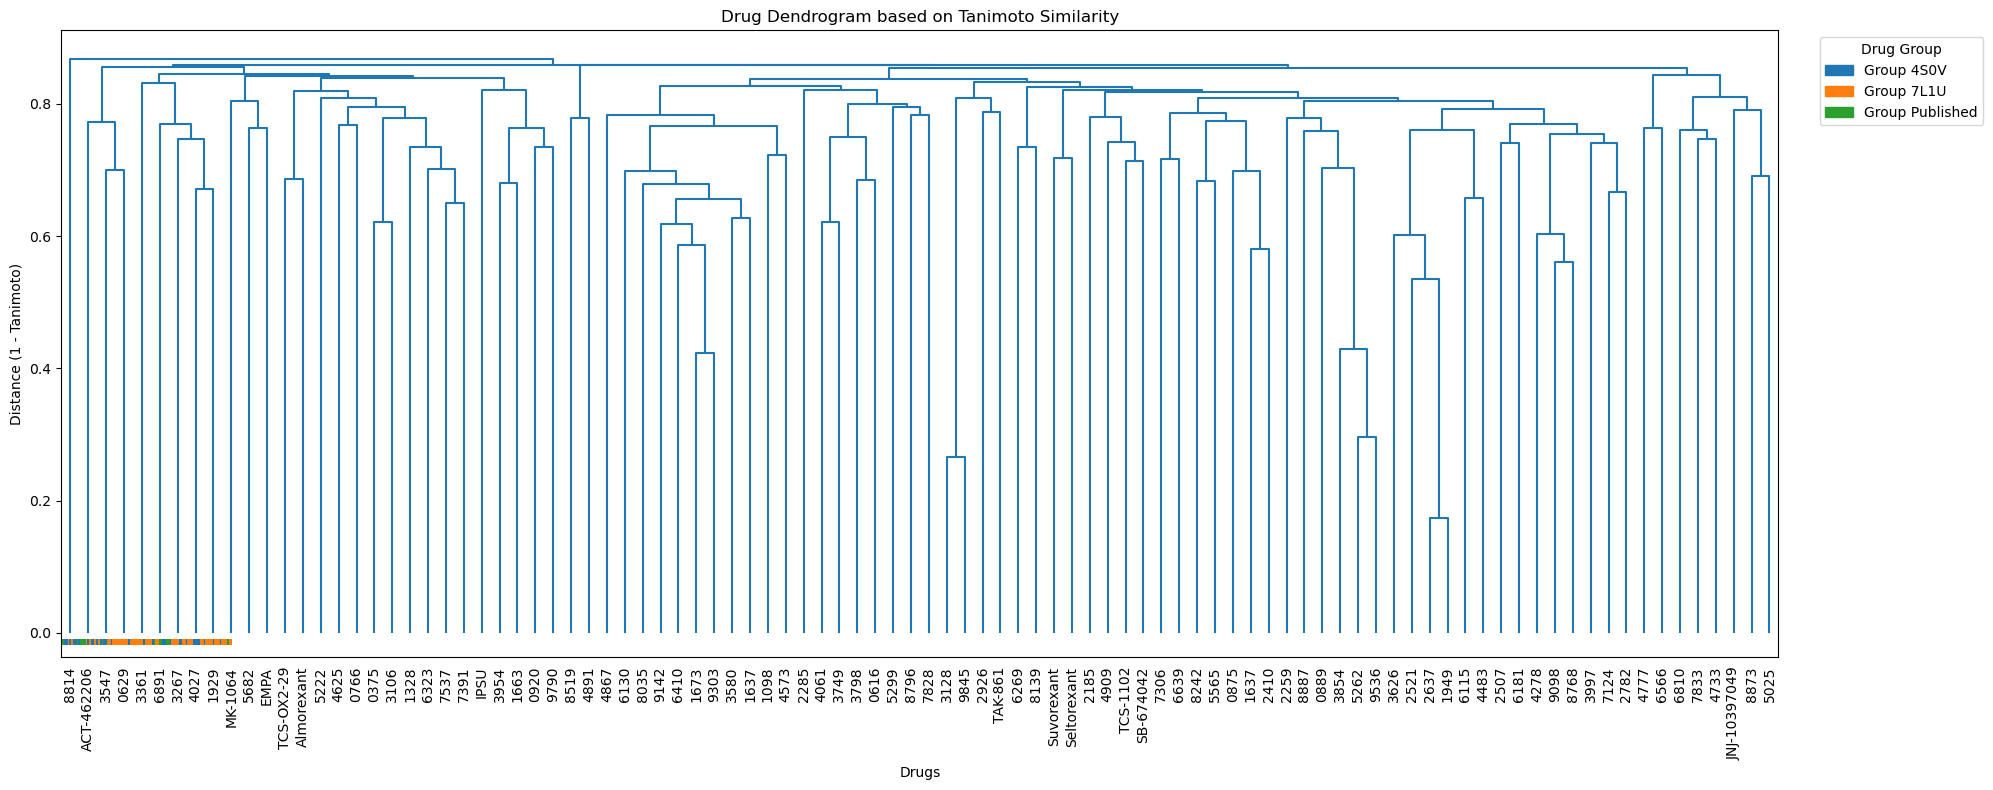

In [31]:
from scipy.cluster.hierarchy import set_link_color_palette
# Set all dendrogram branches to gray
set_link_color_palette(['#888888'])

fig, ax = plt.subplots(figsize=(20, 8))

# Create color mapping
group_colors = sns.color_palette("tab10", df['group'].nunique())
group_lut = dict(zip(sorted(df['group'].unique()), group_colors))

# Build labels and mapping
labels = df['short_id'].values
id_to_group = dict(zip(df['short_id'], df['group']))
id_to_color = {sid: group_lut[id_to_group[sid]] for sid in df['short_id']}

# Draw dendrogram
dendro = dendrogram(
    Z,
    labels=labels,
    leaf_rotation=90,
    leaf_font_size=10,
    ax=ax,
    color_threshold=0  # make all links same color
)

# Get leaf order
leaf_labels = dendro['ivl']  # short_ids in display order
group_colors_ordered = [id_to_color[sid] for sid in leaf_labels]

# Draw color bar under leaf labels
ymin, ymax = ax.get_ylim()
bar_y = ymin - (ymax - ymin) * 0.02
bar_height = (ymax - ymin) * 0.01

for i, color in enumerate(group_colors_ordered):
    ax.add_patch(plt.Rectangle((i - 0.5, bar_y), 1.0, bar_height, color=color, linewidth=0))

# Extend the y-limit to make room
ax.set_ylim(bar_y - bar_height * 2, ymax)

# Add group legend
handles = [mpatches.Patch(color=group_lut[g], label=f'Group {g}') for g in sorted(group_lut)]
ax.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc='upper left', title='Drug Group')

# Final labels
plt.title("Drug Dendrogram based on Tanimoto Similarity")
plt.xlabel("Drugs")
plt.ylabel("Distance (1 - Tanimoto)")
plt.tight_layout()
plt.show()

In [32]:
"""
from scipy.cluster.hierarchy import set_link_color_palette
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Reset link colors to neutral gray
set_link_color_palette(['#888888'])

fig, ax = plt.subplots(figsize=(20, 8))

# Group → Color map
group_colors = sns.color_palette("tab10", df['group'].nunique())
group_lut = dict(zip(sorted(df['group'].unique()), group_colors))
id_to_group = dict(zip(df['short_id'], df['group']))

# Dendrogram
dendro = dendrogram(
    Z,
    labels=df['short_id'].values,
    leaf_rotation=90,
    leaf_font_size=10,
    ax=ax,
    color_threshold=0
)

# Get the leaf labels in the order displayed
leaf_labels = dendro['ivl']
group_colors_ordered = [group_lut[id_to_group[sid]] for sid in leaf_labels]

# Get x-axis tick positions after plotting
tick_positions = ax.get_xticks()

# Compute y position for color bar
ymin, ymax = ax.get_ylim()
bar_y = ymin - (ymax - ymin) * 0.02
bar_height = (ymax - ymin) * 0.01

# Draw a correctly aligned rectangle under each label
bar_width = 5           # Wider bars
bar_height = (ymax - ymin) * 0.03  # Taller bars (was 0.01)

bar_y = ymin - (ymax - ymin) * 0.05  # drop it further down
ax.set_ylim(bar_y - bar_height * 2, ymax)

for x, color in zip(tick_positions, group_colors_ordered):
    ax.add_patch(plt.Rectangle((x - bar_width / 2, bar_y), bar_width, bar_height, color=color, linewidth=0))


# Extend y-limit to make room
ax.set_ylim(bar_y - bar_height * 2, ymax)


# Add legend
handles = [mpatches.Patch(color=group_lut[g], label=f'Group {g}') for g in sorted(group_lut)]
ax.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc='upper left', title='Drug Group')

# First legend: Drug Groups
group_legend = ax.legend(
    handles=handles,
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    title='Drug Group'
)

# Add it explicitly
ax.add_artist(group_legend)

import matplotlib.cm as cm
import matplotlib.colors as mcolors

from matplotlib.colors import LinearSegmentedColormap, Normalize

# Create custom magenta-to-green colormap
custom_cmap = LinearSegmentedColormap.from_list("magenta_to_green", ["magenta", "green"])

# Normalize RLU values
norm = Normalize(vmin=0, vmax=1)  # You can adjust vmax if needed

# Create color map for normalized_rlu_10uM
norm = mcolors.Normalize(vmin=0, vmax=1)  # Adjust if values go beyond 1
cmap = cm.get_cmap(custom_cmap)
nan_color = 'white'  # color for NaN

# Map drug to rlu value color
id_to_rlu = dict(zip(df['short_id'], df['normalized_rlu_10uM']))
rlu_colors_ordered = [
    cmap(norm(id_to_rlu[sid])) if pd.notna(id_to_rlu[sid]) else nan_color
    for sid in leaf_labels
]

# Parameters
group_bar_y = ymin - (ymax - ymin) * 0.05
group_bar_height = (ymax - ymin) * 0.03

rlu_bar_y = group_bar_y - group_bar_height * 1.5
rlu_bar_height = group_bar_height * 1.0
bar_width = 5

# Draw group bars (already done above)
for x, color in zip(tick_positions, group_colors_ordered):
    ax.add_patch(plt.Rectangle((x - bar_width / 2, group_bar_y),
                               bar_width, group_bar_height, color=color, linewidth=0))

# Draw RLU bars
for x, color in zip(tick_positions, rlu_colors_ordered):
    ax.add_patch(plt.Rectangle((x - bar_width / 2, rlu_bar_y),
                               bar_width, rlu_bar_height, color=color, linewidth=0))

# Adjust y-limits to make room
ax.set_ylim(rlu_bar_y - rlu_bar_height * 2, ymax)


from matplotlib.colorbar import ColorbarBase

# Create new axis for colorbar
cbar_ax = fig.add_axes([0.925, 0.235, 0.015, 0.4])  # [left, bottom, width, height]
ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='vertical', label='Normalized RLU (10 µM)')

offtarget_colors = {0: 'black', 1: 'red', 2: 'white'}
toxicity_colors = {0: 'black', 1: 'red', 2: 'white'}

id_to_off = dict(zip(df['short_id'], df['off_target']))
id_to_tox = dict(zip(df['short_id'], df['toxicity']))

off_colors_ordered = [offtarget_colors[id_to_off[sid]] for sid in leaf_labels]
tox_colors_ordered = [toxicity_colors[id_to_tox[sid]] for sid in leaf_labels]


# Bar spacing & dimensions
bar_width = 5
bar_height = (ymax - ymin) * 0.03

# Y positions for each bar row
group_bar_y   = ymin - (ymax - ymin) * 0.05
#rlu_bar_y     = group_bar_y - bar_height * 1.5
#off_bar_y     = rlu_bar_y   - bar_height * 1.5
#tox_bar_y     = off_bar_y   - bar_height * 1.5

# Draw bars
for x, color in zip(tick_positions, group_colors_ordered):
    ax.add_patch(plt.Rectangle((x - bar_width/2, group_bar_y), bar_width, bar_height, color=color, linewidth=0))

for x, color in zip(tick_positions, rlu_colors_ordered):
    ax.add_patch(plt.Rectangle((x - bar_width/2, rlu_bar_y), bar_width, bar_height, color=color, linewidth=0))

for x, color in zip(tick_positions, off_colors_ordered):
    ax.add_patch(plt.Rectangle((x - bar_width/2, off_bar_y), bar_width, bar_height, color=color, linewidth=0))

for x, color in zip(tick_positions, tox_colors_ordered):
    ax.add_patch(plt.Rectangle((x - bar_width/2, tox_bar_y), bar_width, bar_height, color=color, linewidth=0))


# Update y-limit to fit everything
ax.set_ylim(tox_bar_y - bar_height * 2, ymax)

legend_offtox = [
    mpatches.Patch(color='black', label='0: No'),
    mpatches.Patch(color='red', label='1: Yes'),
    mpatches.Patch(color='white', edgecolor='black', label='2: Not measured')
]

#ax.legend(handles=legend_offtox, bbox_to_anchor=(1.02, 0.6), loc='upper left', title='Off-target / Toxicity')

# Second legend: Off-target / Toxicity
ax.legend(
    handles=legend_offtox,
    bbox_to_anchor=(1.02, -0.3),  # Lower down
    loc='upper left',
    title='Off-target / Toxicity'
)

ax.set_ylim(tox_bar_y - bar_height * 2, ymax)  # Keep enough space for all bars
ax.tick_params(axis='y', which='both', direction='out')  # tidy appearance
ax.set_yticks([ytick for ytick in ax.get_yticks() if ytick >= 0])  # hide negative ticks

#ax.set_ylim(0, ymax)

# Choose a fixed x position left of first tick, for example:
text_x = tick_positions[0] - 10  # Adjust offset so text is visible and not clipped

# Add text labels aligned with each bar row
ax.text(text_x, group_bar_y + bar_height/2, "Group", va='center', ha='right', fontsize=12)
#ax.text(text_x, rlu_bar_y + bar_height/2, "Normalized RLU", va='center', ha='right', fontsize=12)
#ax.text(text_x, off_bar_y + bar_height/2, "Off-target", va='center', ha='right', fontsize=12)
#ax.text(text_x, tox_bar_y + bar_height/2, "Toxicity", va='center', ha='right', fontsize=12)


# Titles and labels
#plt.title("Drug Dendrogram based on Tanimoto Similarity")
ax.set_title("Drug Dendrogram based on Tanimoto Similarity")
#ax.set_xlabel("Drugs")
ax.set_ylabel("Distance (1 - Tanimoto)")
#plt.xlabel("Drugs")
#plt.ylabel("Distance (1 - Tanimoto)")
plt.tight_layout()

plt.savefig('drug_dendrogram.png', dpi=300, bbox_inches='tight')

plt.show()
"""

'\nfrom scipy.cluster.hierarchy import set_link_color_palette\nimport matplotlib.patches as mpatches\nimport matplotlib.pyplot as plt\nimport numpy as np\nimport seaborn as sns\n\n# Reset link colors to neutral gray\nset_link_color_palette([\'#888888\'])\n\nfig, ax = plt.subplots(figsize=(20, 8))\n\n# Group → Color map\ngroup_colors = sns.color_palette("tab10", df[\'group\'].nunique())\ngroup_lut = dict(zip(sorted(df[\'group\'].unique()), group_colors))\nid_to_group = dict(zip(df[\'short_id\'], df[\'group\']))\n\n# Dendrogram\ndendro = dendrogram(\n    Z,\n    labels=df[\'short_id\'].values,\n    leaf_rotation=90,\n    leaf_font_size=10,\n    ax=ax,\n    color_threshold=0\n)\n\n# Get the leaf labels in the order displayed\nleaf_labels = dendro[\'ivl\']\ngroup_colors_ordered = [group_lut[id_to_group[sid]] for sid in leaf_labels]\n\n# Get x-axis tick positions after plotting\ntick_positions = ax.get_xticks()\n\n# Compute y position for color bar\nymin, ymax = ax.get_ylim()\nbar_y = ymin 

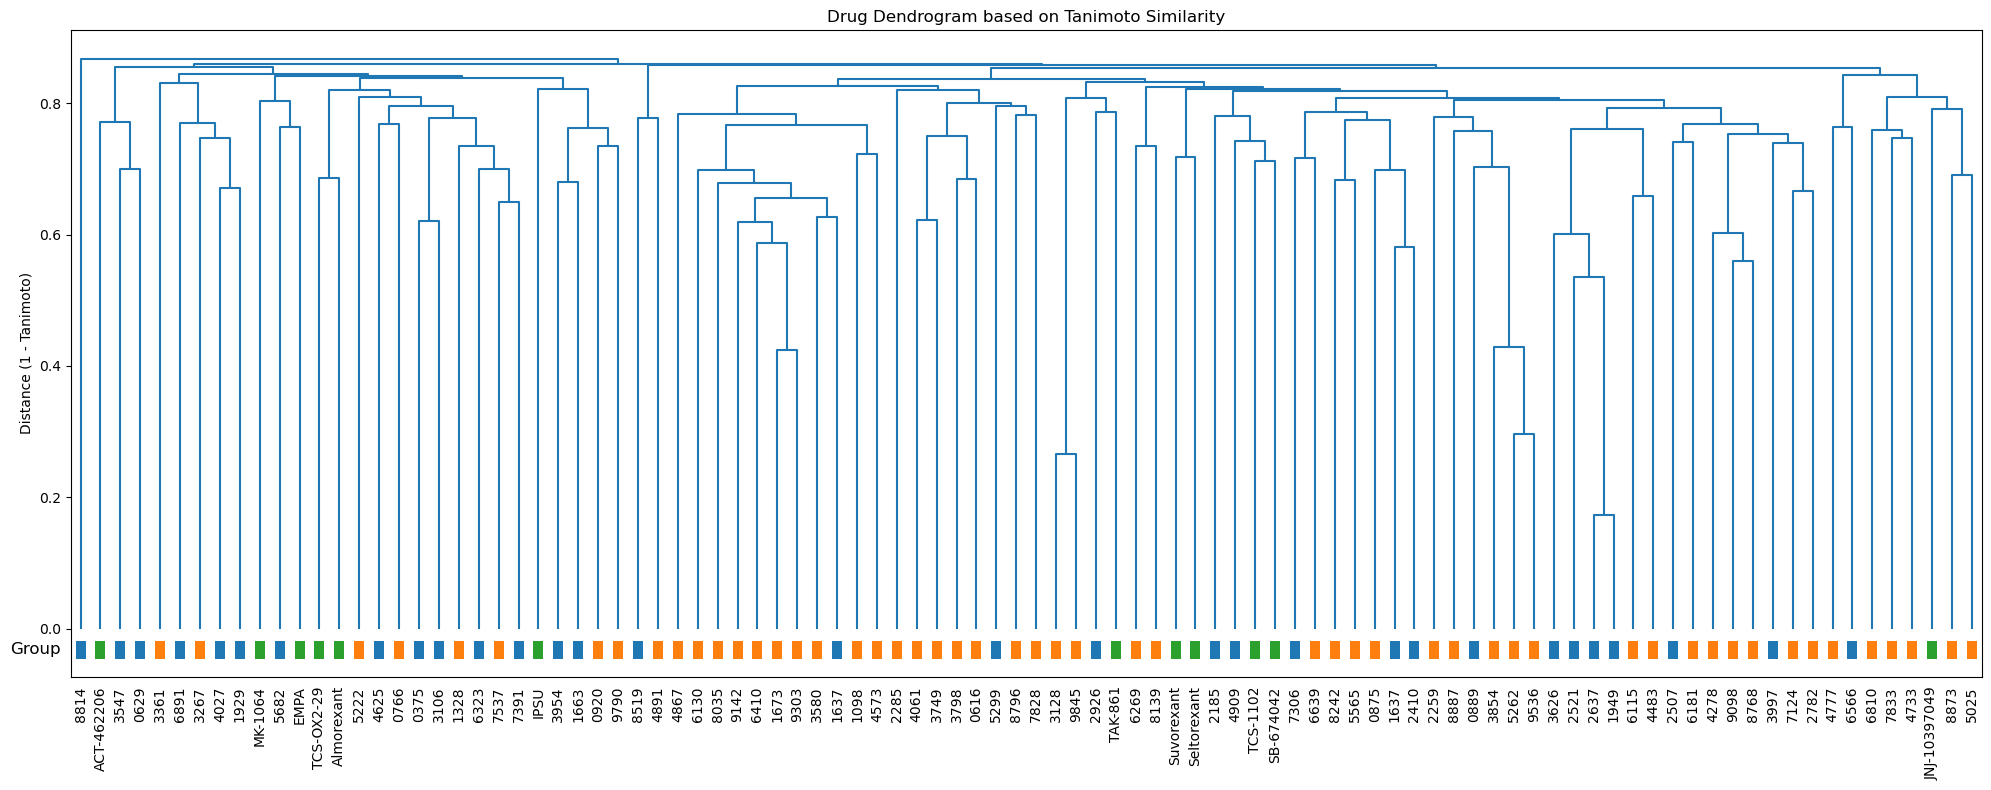

In [33]:
from scipy.cluster.hierarchy import set_link_color_palette, dendrogram
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

# Reset link colors to neutral gray
set_link_color_palette(['#888888'])

fig, ax = plt.subplots(figsize=(20, 8))

# Group → Color map
group_colors = sns.color_palette("tab10", df['group'].nunique())
group_lut = dict(zip(sorted(df['group'].unique()), group_colors))
id_to_group = dict(zip(df['short_id'], df['group']))

# Dendrogram
dendro = dendrogram(
    Z,
    labels=df['short_id'].values,
    leaf_rotation=90,
    leaf_font_size=10,
    ax=ax,
    color_threshold=0
)

# Get the leaf labels in the order displayed
leaf_labels = dendro['ivl']
group_colors_ordered = [group_lut[id_to_group[sid]] for sid in leaf_labels]

# Get x-axis tick positions after plotting
tick_positions = ax.get_xticks()

# Compute y position for color bar
ymin, ymax = ax.get_ylim()
bar_y = ymin - (ymax - ymin) * 0.02
bar_height = (ymax - ymin) * 0.01

# Draw a correctly aligned rectangle under each label
bar_width = 5           # Wider bars
bar_height = (ymax - ymin) * 0.03  # Taller bars
bar_y = ymin - (ymax - ymin) * 0.05  # drop further down
ax.set_ylim(bar_y - bar_height * 2, ymax)

for x, color in zip(tick_positions, group_colors_ordered):
    ax.add_patch(plt.Rectangle((x - bar_width / 2, bar_y), bar_width, bar_height, 
                               color=color, linewidth=0))

# Extend y-limit to make room
ax.set_ylim(bar_y - bar_height, ymax)

# Legend for groups
handles = [mpatches.Patch(color=group_lut[g], label=f'Group {g}') for g in sorted(group_lut)]
group_legend = ax.legend(
    handles=handles,
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    title='Drug Group'
)
ax.add_artist(group_legend)

# ================================
# Commented out: RLU, Off-target, Toxicity
# (color maps, bars, legends, and labels)
# ================================
"""
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colorbar import ColorbarBase

# --- RLU colormap and bars ---
custom_cmap = LinearSegmentedColormap.from_list("magenta_to_green", ["magenta", "green"])
norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = cm.get_cmap(custom_cmap)
nan_color = 'white'
id_to_rlu = dict(zip(df['short_id'], df['normalized_rlu_10uM']))
rlu_colors_ordered = [
    cmap(norm(id_to_rlu[sid])) if pd.notna(id_to_rlu[sid]) else nan_color
    for sid in leaf_labels
]

# --- Off-target & toxicity colors ---
offtarget_colors = {0: 'black', 1: 'red', 2: 'white'}
toxicity_colors = {0: 'black', 1: 'red', 2: 'white'}
id_to_off = dict(zip(df['short_id'], df['off_target']))
id_to_tox = dict(zip(df['short_id'], df['toxicity']))
off_colors_ordered = [offtarget_colors[id_to_off[sid]] for sid in leaf_labels]
tox_colors_ordered = [toxicity_colors[id_to_tox[sid]] for sid in leaf_labels]

# --- Legends ---
legend_offtox = [
    mpatches.Patch(color='black', label='0: No'),
    mpatches.Patch(color='red', label='1: Yes'),
    mpatches.Patch(color='white', edgecolor='black', label='2: Not measured')
]
ax.legend(handles=legend_offtox, bbox_to_anchor=(1.02, -0.3), loc='upper left',
          title='Off-target / Toxicity')
"""

# Label for group bars
text_x = tick_positions[0] - 10
ax.text(text_x, bar_y + bar_height/2, "Group", va='center', ha='right', fontsize=12)

# Titles and labels
ax.set_title("Drug Dendrogram based on Tanimoto Similarity")
ax.set_ylabel("Distance (1 - Tanimoto)")
plt.tight_layout()

plt.savefig('drug_dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()
